In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

In [78]:
#PARTE 1 - PREPARAMOS NUESTRO ARCHIVOS DE DATOS
#PREPARAMOS NUESTO DATA FRAME CON LOS DATOS DE LA ESTACION DE LA ANTARTIDA
url="https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt"
col=["ubicacion","Año", "Mes","Dia","hora","minuto","segundo","fecha","CO2","CO2_std_dev","mediciones","latitud","longitud","altitud","elevación","altura de muestra","calidad"]
df_data = pd.read_csv(url, names=col, encoding="cp1251", sep="\s+", header=None, skiprows=151, skipfooter=0, engine="python")
#VERIFICAMOS QUE NUESTRO DATA FRAME SE HAYA CREADO CORRECTAMENTE
#df_data.head()
#df_data.tail()
#df_data.shape
#df_data.info
#CONVERTIMOS LOS DATOS DE RELLENO A DATOS NULOS
str_Nulo = -999.99
df_data1 = df_data.replace(to_replace=str_Nulo, value='', regex=True)
df_data1["CO2"] = pd.to_numeric(df_data1["CO2"], errors='coerce')
#VERIFICAMOS EL NUMERO DE DATOS FALTANTES
df_data1.isnull().sum()
df_data1.head()
df_data2 = df_data1.copy()
#CREAMOS OTRO DATAFRAME PROVISIONAL EN EL QUE ALMACENAREMOS LA FECHA EN FORMATO DATETIME, DESPUES REEMPLAZAREMOS LA COLUMNA QUE CONTIENE LA FECHA EN FORMATO DECIMAL DE NUESTOS DATOS POR UNA COLUMNA CON LA FECHA EN FORMATO DATETIME
df_fecha=pd.DataFrame({"year" : df_data2["Año"], "month" : df_data2["Mes"],"day" : df_data2["Dia"]})
df_fecha=pd.to_datetime(df_fecha)
#print (df_fecha.head())
#print (df_fecha.dtypes)
#print (df_data2.head())
#print (df_fecha.shape)
df_data2["fecha"]=df_fecha
df_data2.head()
df_data2.dtypes
df_data=df_data2[(df_data2["Año"]>=1980)&(df_data2["Año"]<=2019)]
#print(df_data.head())
#df_data.tail()
#AHORA CREAMOS NUESTRA SERIE DE TIEMPO
ts_test = pd.DataFrame({"fecha":df_data["fecha"],"CO2":df_data["CO2"]})
ts_test = ts_test.set_index("fecha") 
#print (ts_test.head())
#ts_test.isnull().sum()
# RELLENAMOS LOS DATOS NULOS Y COMPROBAMOS QUE EL INDICE DE LA FECHA FUNCIONE CORRECTAMENTE
ts_test.ffill(axis=0, inplace=True) 
#ts_test.loc["1981":"1982"]
#ts_test.isnull().sum()


In [76]:
#ANALISIS DE LA SERIE DE TIEMPO

def test_stationarity(df_ts):
  #DEFINIR PROMEDIOS MOVILES
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
 # DEFINIMOS EL TAMAÑO DE LA FIGURA
    plt.rcParams["figure.figsize"] = (20,10)
#GRAFICAMOS LOS PROMEDIOS MOVILES Y LA DESVIACION ESTANDAR JUNTOS LOS DATOS
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Promedio movil')
    plt.plot(rolstd, color='black', label = 'Desviacion estandar movil')
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 #REALIZAMOS LA PRUEBA AUMENTADA DE DICKEY FULLER
    print('Resultados de la Prueba aumentado de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


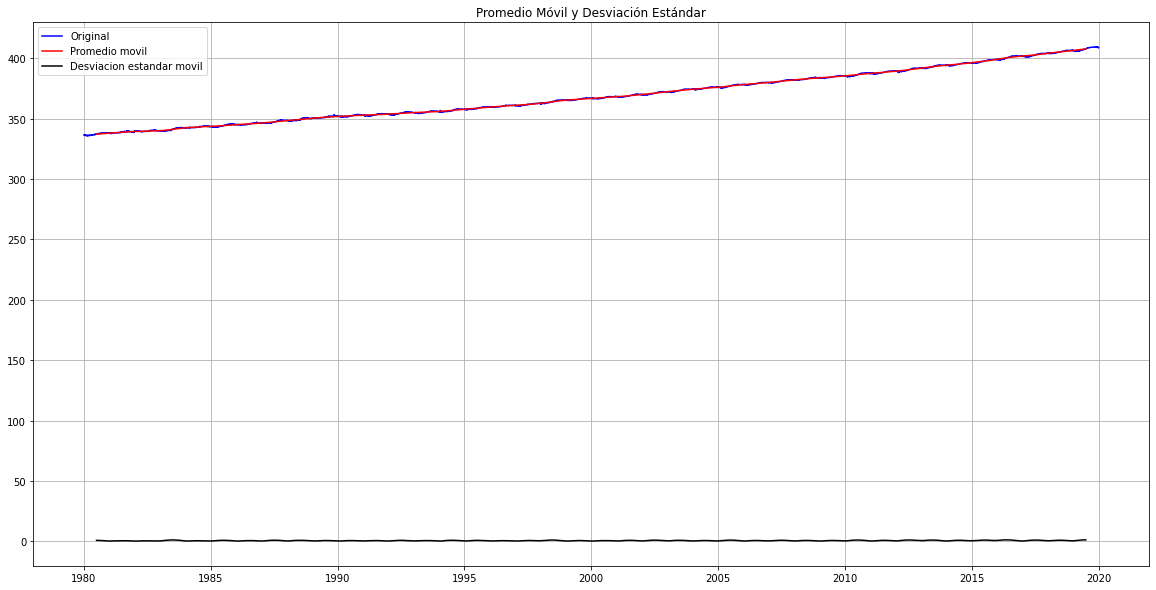

Resultados de la Prueba aumentado de Dickey-Fuller:
Test Statistic                     0.973933
p-value                            0.993983
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


Text(0, 0.5, 'Concentacion de CO2 en escala logaritmica')

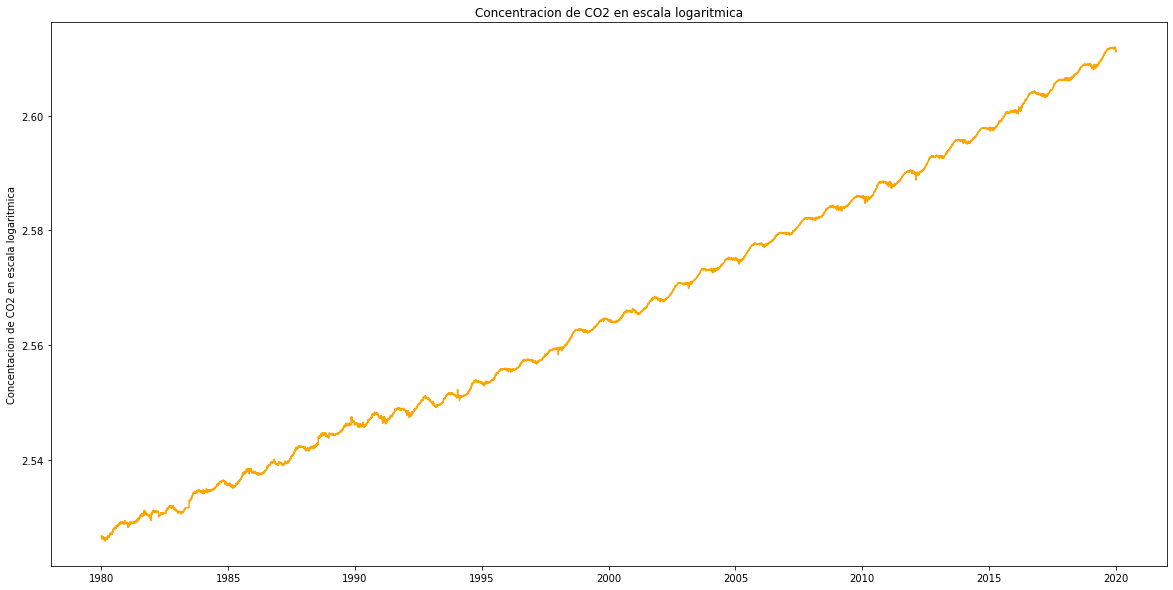

In [84]:
#PROBAMOS LA SERIE DE TIEMPO
test_stationarity(ts_test["CO2"])
#COMO LA SERIE NO ES ESTACIONARIA ENTONCES LA PASAREMOS A ESCALA LOGARITMICA
ts_testlog=np.log10(ts_test["CO2"])
plt.plot(ts_testlog, color="orange")
plt.title("Concentracion de CO2 en escala logaritmica")
plt.ylabel("Concentacion de CO2 en escala logaritmica")

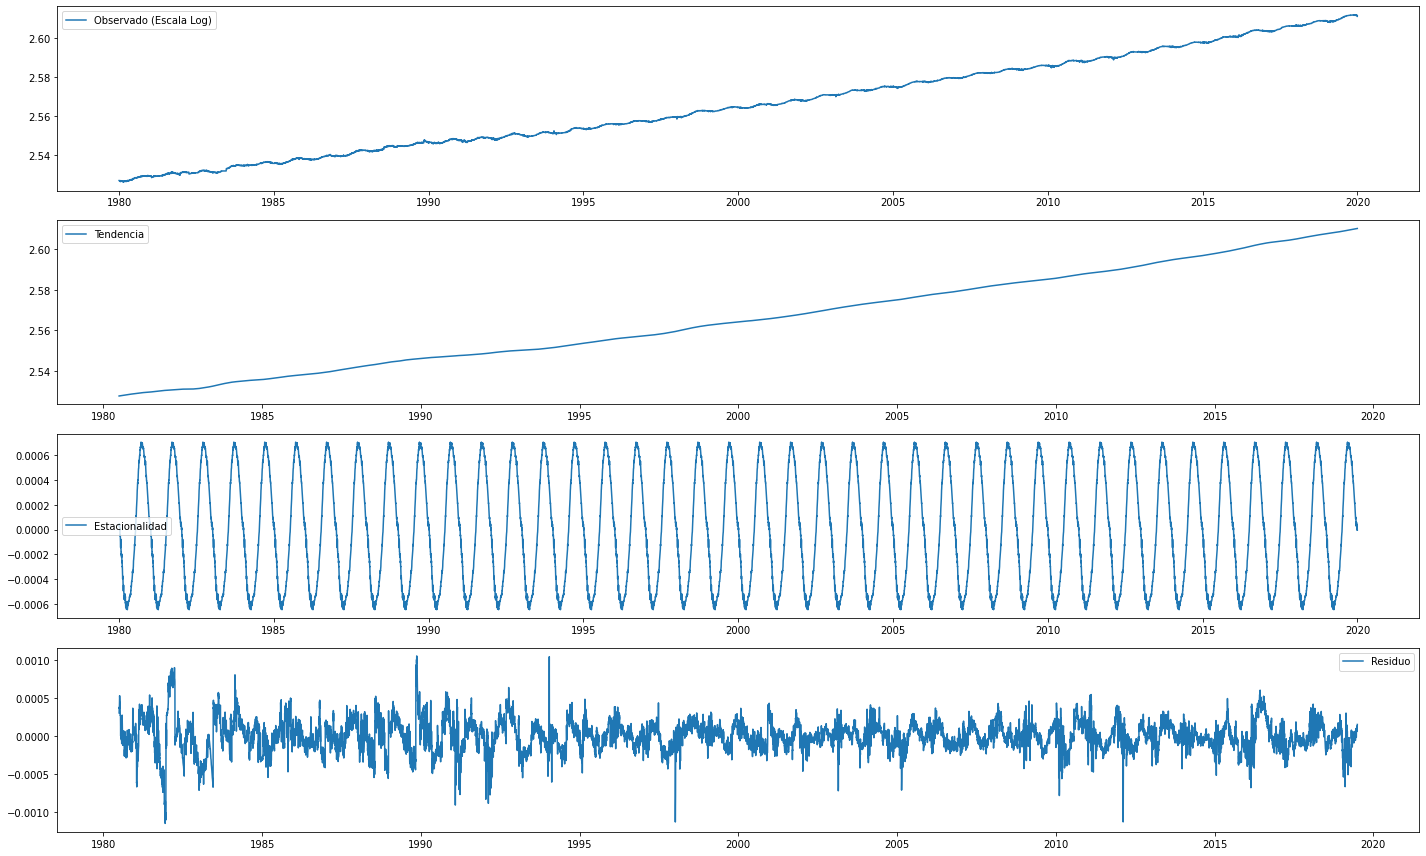

In [98]:
#HACEMOS UNA DESCOMPOSICION ESTACIONAL DE LA SERIE
#hacemos la descomposición de la serie de tiempo, obs=tendencia+estacionalidad+residuo
# Método de descomposición usando la biblioteca statsmodels.tsa
decomposition = sm.tsa.seasonal_decompose(ts_testlog.interpolate(), model='additive', freq=365)
# GRAFICAMOS LOS 3 COMPONENTES
trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid
plt.rcParams["figure.figsize"] = (20,12)
plt.subplot(411)
plt.plot(ts_testlog, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();

**COMENTARIOS ACERCA DE LA DESCOMPOSICION ESTACIONAL DE LA SERIE DE TIEMPO TS_TESTLOG**
Podemos ver de los datos observados que claramente la concentracion de CO2 va en aumento, pero con ligeras variaciones periodicas, sin embargo se percibe el aumento general con el tiempo.
De la serie de tendencia podemos decir que esta va en aumento casi de manera lineal.

De la serie de estacionalidad podemos decir que se ve como las variaciones periodicas varian segun la estacion del año, siendo en los meses de julio-octube cuando se alcanzan estas variaciones maximas estacionarias en la concentacion de CO2

De la serie residual observamos como hay muchas variaciones sin estacionalidad, que son muy erraticas, sin embargo pareciera que toda la serie tiene un promedio movil constante ya que los datos nunca se salen mucho del mismo rango.

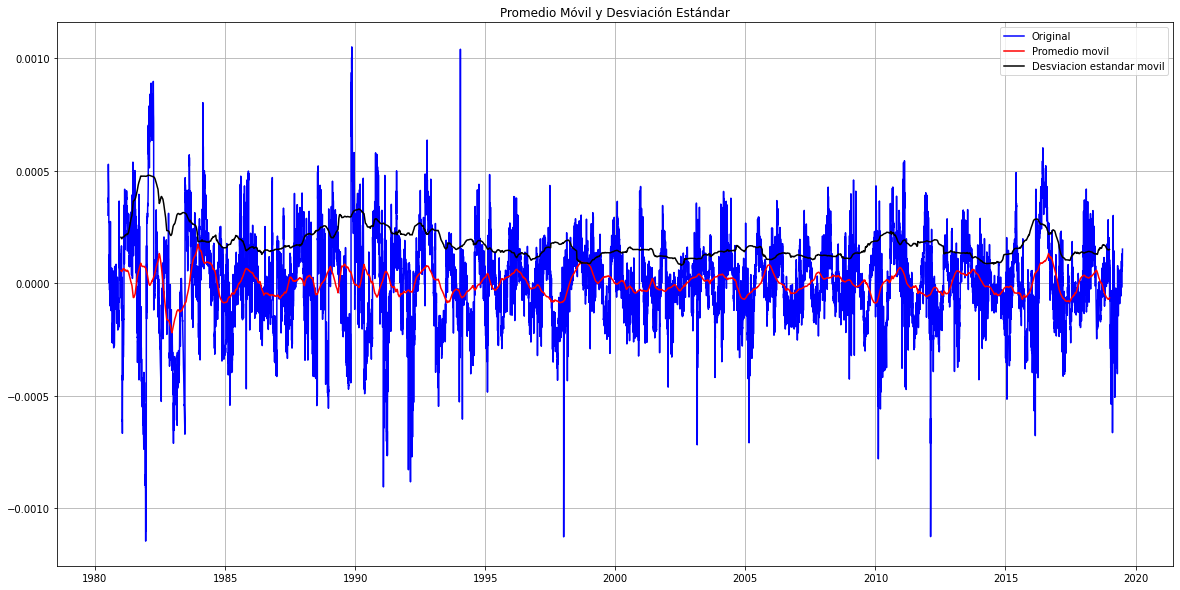

Resultados de la Prueba aumentado de Dickey-Fuller:
Test Statistic                -1.135572e+01
p-value                        9.746288e-21
#Lags Used                     2.800000e+01
Number of Observations Used    1.421700e+04
Critical Value (1%)           -3.430810e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [97]:
#PROBAREMOS LA ESTACIONARIDAD DE LA SERIE RESIDUO
ts_teslogresid=decomposition.resid 
ts_teslogresid.dropna(inplace=True)
test_stationarity(ts_teslogresid)
#podemos ver que la serie residuo es estacionaria

Text(0.5, 1.0, 'Concentracion de CO2 en escala logaritmica (Azul), Promedio movil anual de concentración de CO2 en escala logaritmica (Rojo) ')

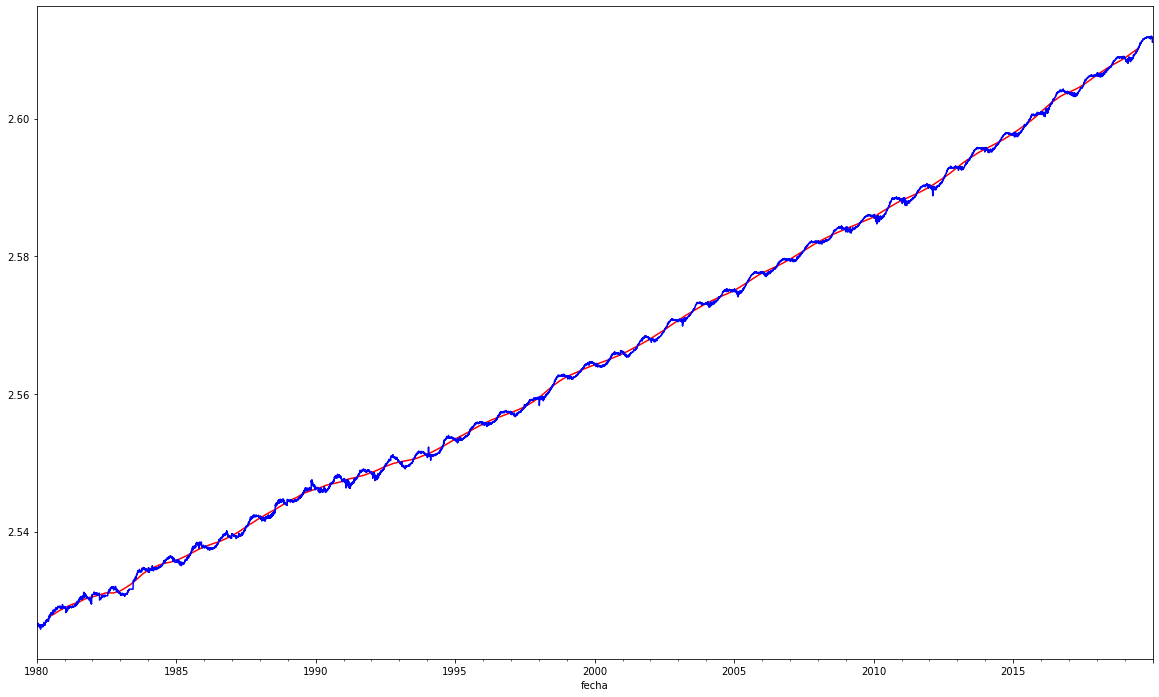

In [108]:
#HACEMOS UN PROMEDIO MOVIL ANUAL DE LA SERIE DE LAS CONCENTRACIONES EN ESCALA LOGARITMICA
ts_logmed=ts_testlog.rolling(365, center=True).mean()
axes=ts_logmed.plot(color="red")
axes=ts_testlog.plot(color="blue")
ax.set_title("Concentracion de CO2 en escala logaritmica (Azul), Promedio movil anual de concentración de CO2 en escala logaritmica (Rojo) ")


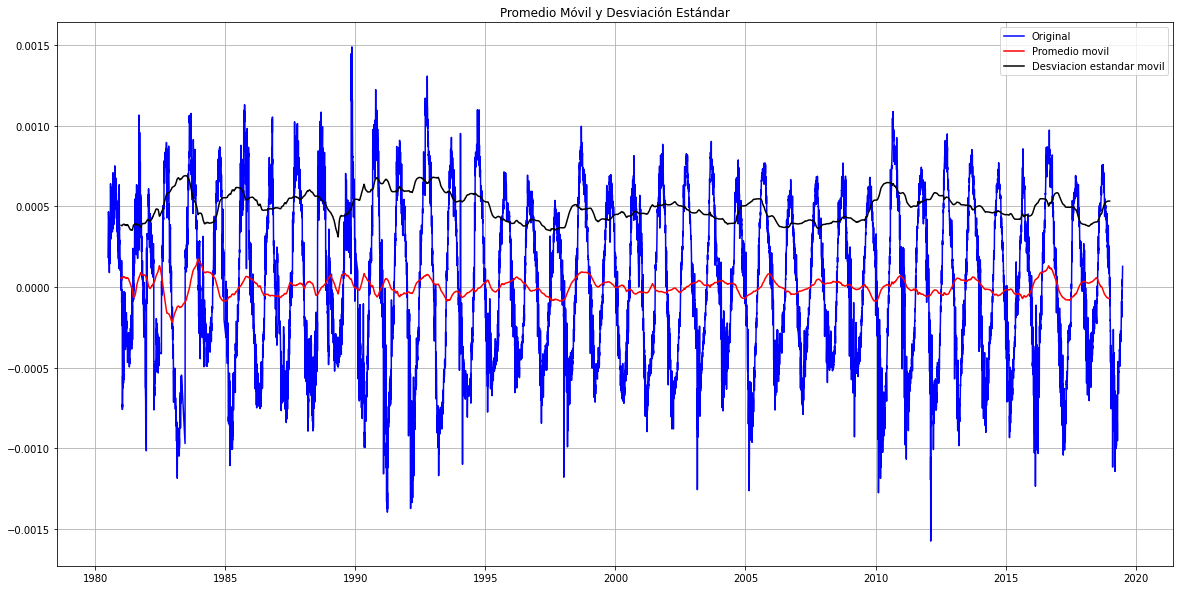

Resultados de la Prueba aumentado de Dickey-Fuller:
Test Statistic                -1.135538e+01
p-value                        9.763779e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.420300e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [115]:
#DEFINIMOS UN NUEVO DATA FRAME COMO LA DIFERENCIA ENTRE EL LOGARITMO ORIGINAL Y EL PROMEDIO MOVIL
df_deltalog =pd.DataFrame(ts_testlog-ts_logmed)
df_deltalog.dropna(inplace=True)
test_stationarity(df_deltalog["CO2"])
#ESTA SERIE ES ESTACIONARIA

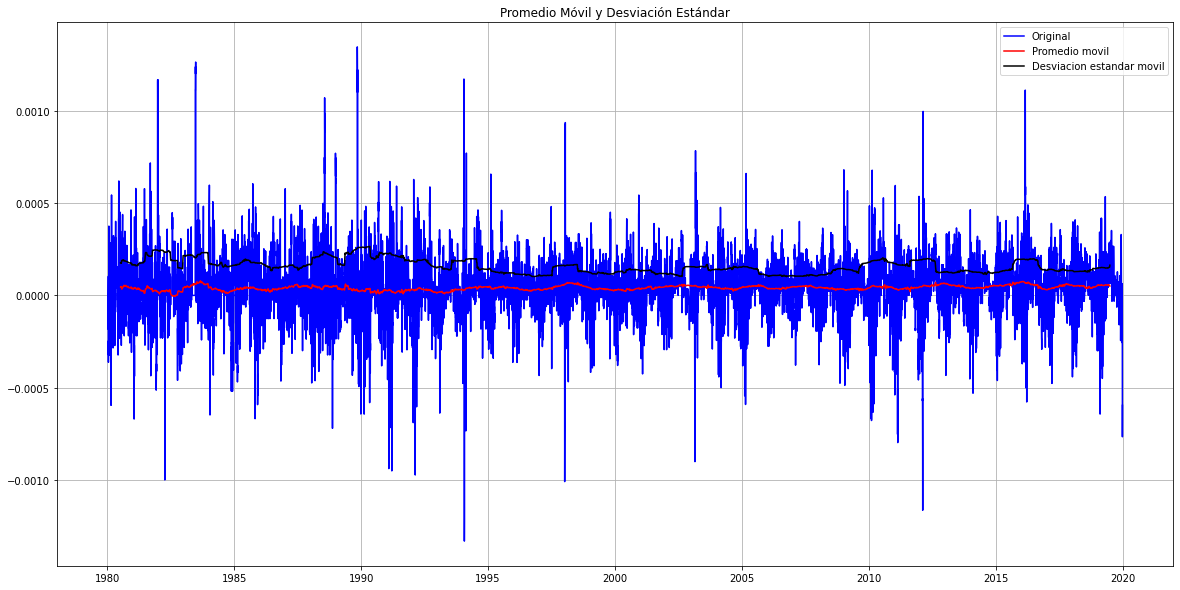

Resultados de la Prueba aumentado de Dickey-Fuller:
Test Statistic                -1.171651e+01
p-value                        1.446943e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.456000e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [121]:
#DIFERENCIAMOS USANDO LA INSTRUCCION SHIFT
ts_testdif=ts_testlog-ts_testlog.shift(periods=7)
ts_testdif.dropna(inplace=True)
#PROBAMOS SU ESTACIONARIDAD
test_stationarity(ts_testdif)
#ESTA SERIE DIFERENCIADAS ES ESTACIONARIA

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


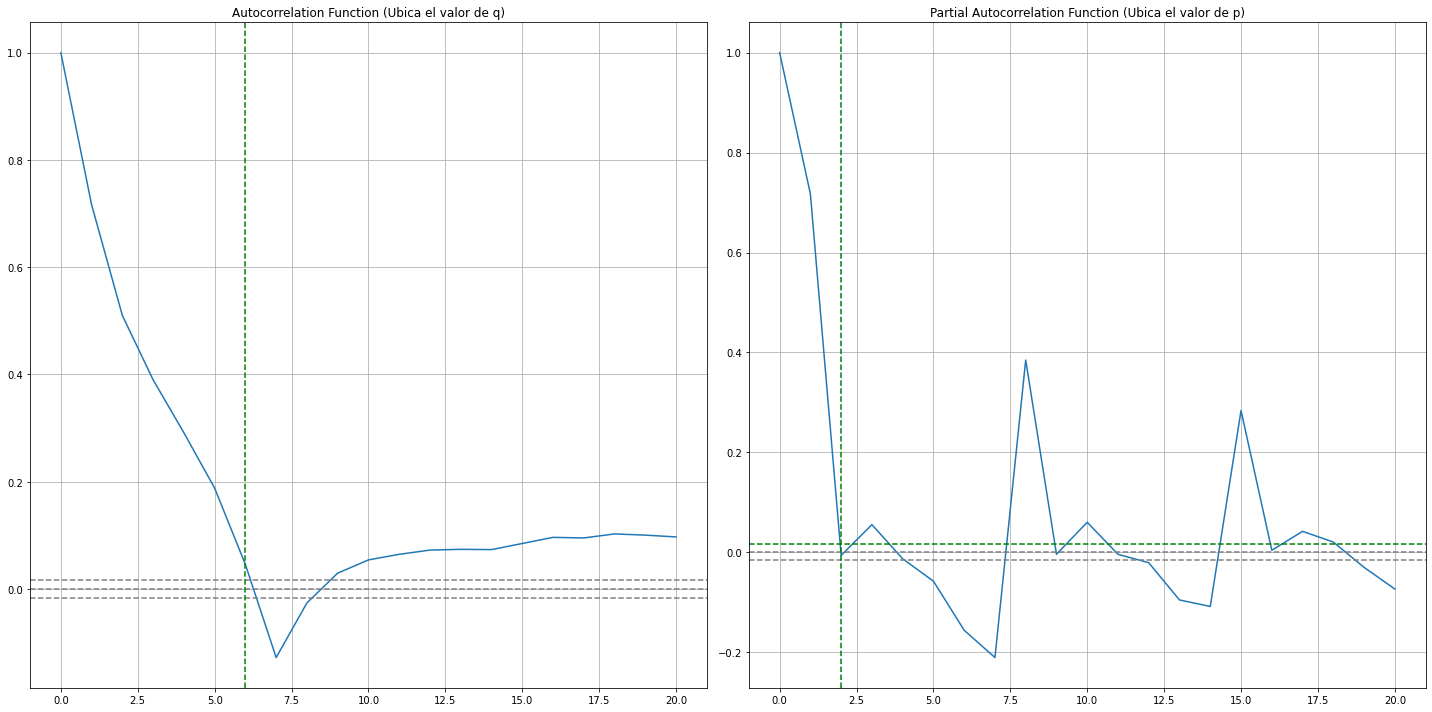

In [127]:
#APLICAMOS UN MODELO ARIMA 
#DEFINIMOS LAS FUNCIONES A USAR 
lag_acf = acf(ts_testdif, nlags=20)
lag_pacf = pacf(ts_testdif, nlags=20, method = 'ols')
plt.rcParams["figure.figsize"] = (20,10)
# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_testdif)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_testdif)), linestyle='--', color='gray')
# Graficamos unas líneas verticales como referencias
plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')
# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_testdif)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_testdif)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')
plt.tight_layout()
#USAREMOS VALOR DE Q=6, Y P=2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14602
Model:                 ARIMA(2, 1, 0)   Log Likelihood              111196.331
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -222384.662
Time:                        06:45:33   BIC                        -222354.306
Sample:                    01-09-1980   HQIC                       -222374.577
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.421e-08    7.4e-07     -0.046      0.963   -1.48e-06    1.42e-06
ar.L1.D.CO2    -0.1601      0.008    -19.642      0.000      -0.176      -0.144
ar.L2.D.CO2    -0.1736      0.008    -21.292    

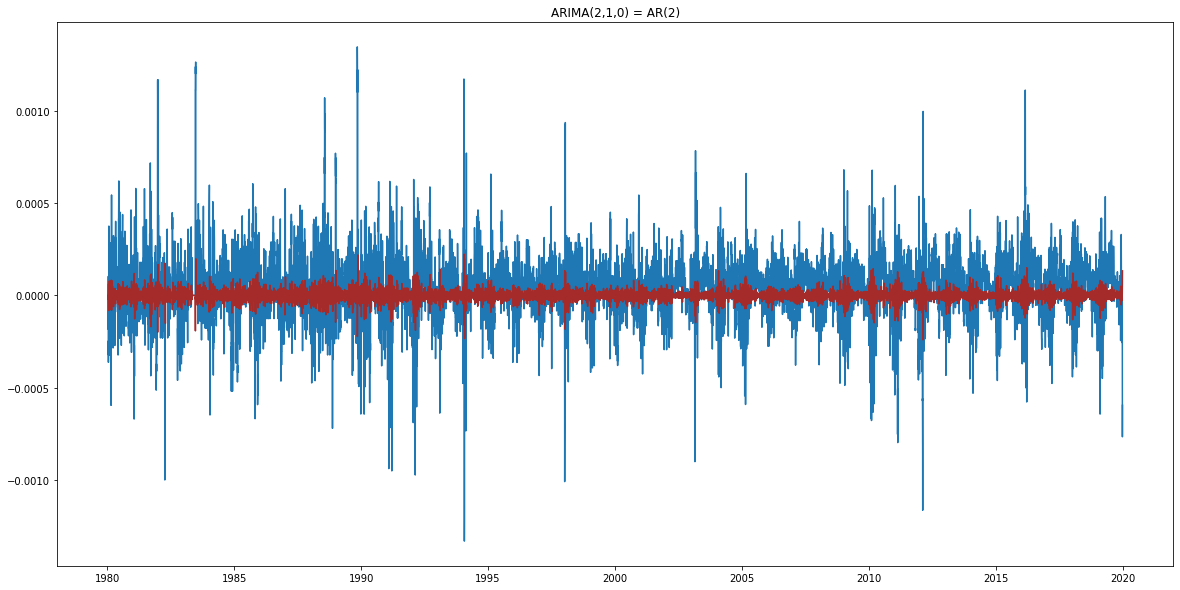

In [130]:
#USAMOS EL CRITERO AKAIKE PARA SELECCIONAR EL MEJOR MDODELO
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_testdif, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_testdif)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14602
Model:                 ARIMA(0, 1, 4)   Log Likelihood              111445.054
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -222878.108
Time:                        06:46:31   BIC                        -222832.575
Sample:                    01-09-1980   HQIC                       -222862.981
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.565e-08    3.8e-07     -0.041      0.967    -7.6e-07    7.28e-07
ma.L1.D.CO2    -0.1818      0.005    -33.287      0.000      -0.193      -0.171
ma.L2.D.CO2    -0.1844      0.004    -46.758    

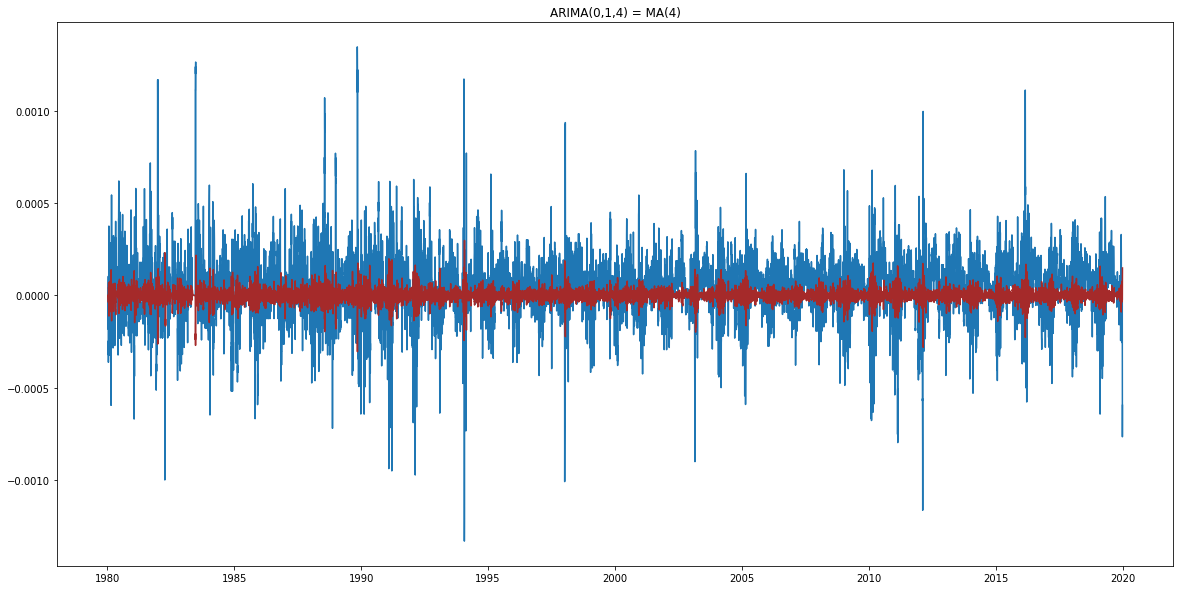

In [132]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_testdif, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_testdif)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14602
Model:                 ARIMA(2, 1, 4)   Log Likelihood              111333.420
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -222650.840
Time:                        06:47:46   BIC                        -222590.128
Sample:                    01-09-1980   HQIC                       -222630.670
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.676e-08   5.33e-07     -0.050      0.960   -1.07e-06    1.02e-06
ar.L1.D.CO2    -0.1595      0.038     -4.191      0.000      -0.234      -0.085
ar.L2.D.CO2    -0.1545        nan        nan    

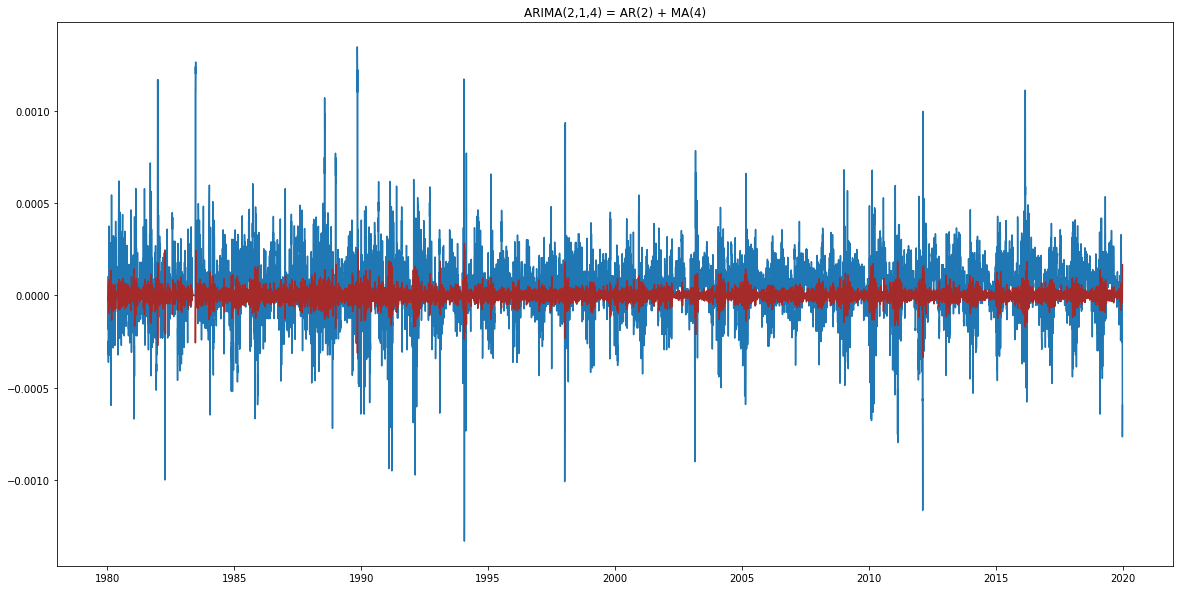

In [133]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_testdif, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_testdif)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [137]:
#HACEMOS UNA SERIE DE TIEMPO CON LOS RESULTADOS DE LA PREDICCION
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)



fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
dtype: float64
fecha
2019-12-27    2.611744
2019-12-28    2.611699
2019-12-29    2.611392
2019-12-30    2.611166
2019-12-31    2.611432
dtype: float64


In [143]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_testlog, index = ts_testlog.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head(10))
print(predictions_ARIMA_log.tail())

fecha
1980-01-01         NaN
1980-01-02         NaN
1980-01-03         NaN
1980-01-04         NaN
1980-01-05         NaN
1980-01-06         NaN
1980-01-07         NaN
1980-01-08         NaN
1980-01-09    2.526572
1980-01-10    2.526552
dtype: float64
fecha
2019-12-27    2.611744
2019-12-28    2.611699
2019-12-29    2.611392
2019-12-30    2.611166
2019-12-31    2.611432
dtype: float64


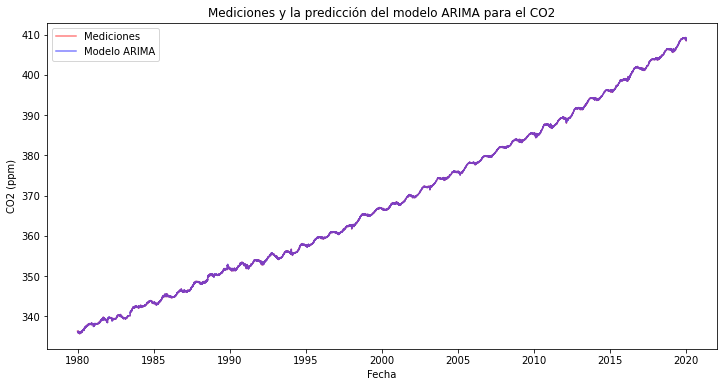

In [150]:
#PASAMOS DE LOGARITMO A DATO EN SUS UNDIADES NORMALES
predictions_ARIMA = 10**(predictions_ARIMA_log)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test, label='Mediciones', color="red", alpha=0.5);
plt.plot(predictions_ARIMA, label='Modelo ARIMA', color="blue", alpha=0.5);
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('Mediciones y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');
# PODEMOS VER QUE LAS PREDICCIONES Y LAS MEDICIONES ESTAN CASI TRASLAPADAS

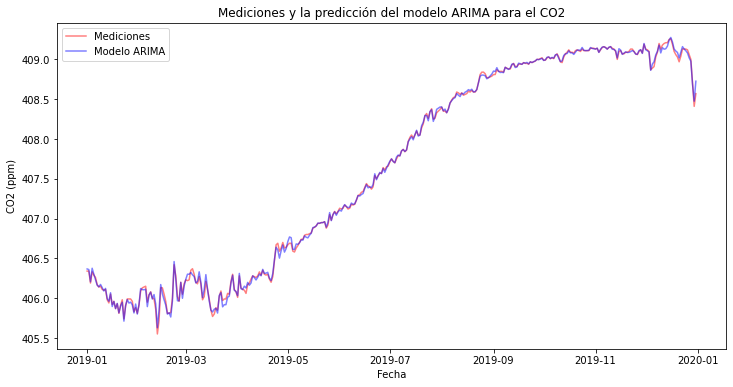

In [153]:
#AHORA HACEMOS EL CONSTRASTE PARA UN AÑO
predictions_ARIMA = 10**(predictions_ARIMA_log)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test.loc["2019-01":"2019-12"], label='Mediciones', color="red", alpha=0.5);
plt.plot(predictions_ARIMA["2019-01":"2019-12"], label='Modelo ARIMA', color="blue", alpha=0.5);
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('Mediciones y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');

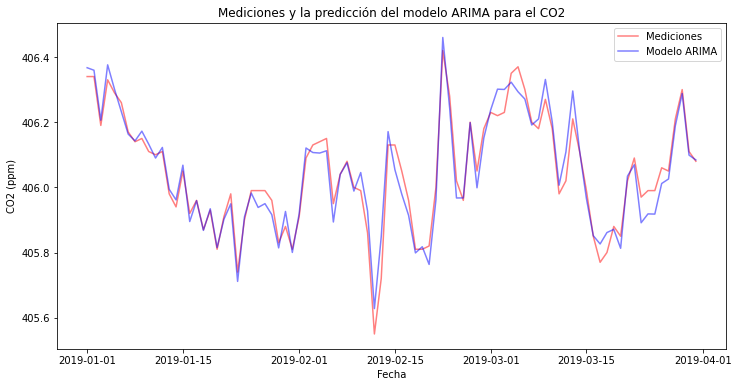

In [154]:
#AHORA HACEMOS EL CONSTRASTE PARA DOS MESES
predictions_ARIMA = 10**(predictions_ARIMA_log)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test.loc["2019-01":"2019-03"], label='Mediciones', color="red", alpha=0.5);
plt.plot(predictions_ARIMA["2019-01":"2019-03"], label='Modelo ARIMA', color="blue", alpha=0.5);
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('Mediciones y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');

In [157]:
#CALCULAMOS EL ERROR DE NUESTRO MODELO
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test["CO2"])**2))
print('RMSE:', RMSE)

RMSE: 0.028328568424029605


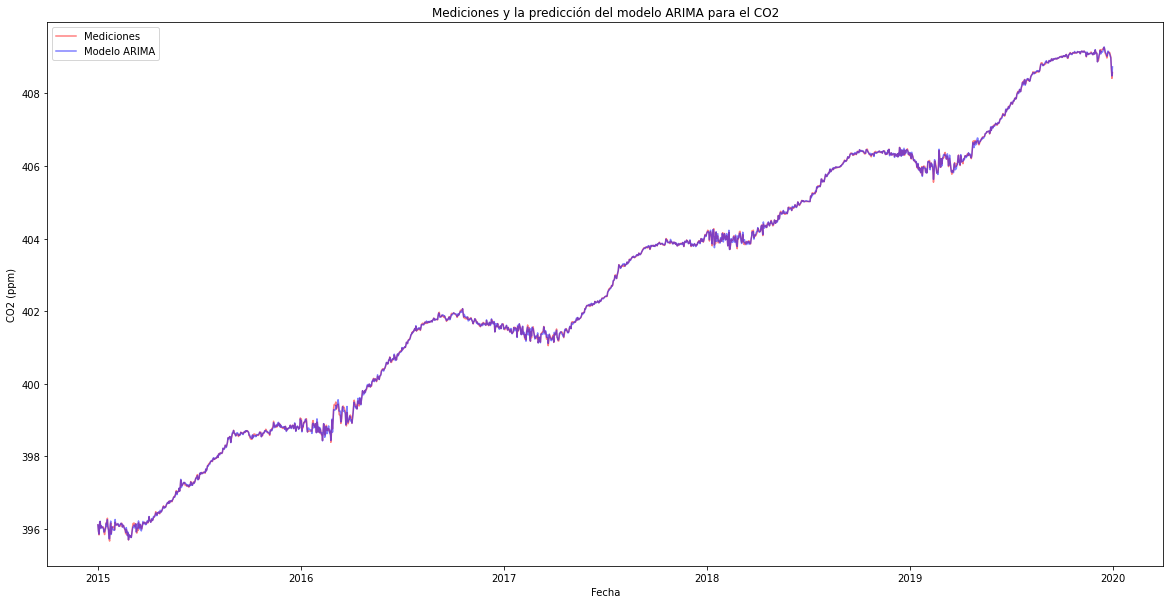

In [159]:
#AHORA HACEMOS EL CONSTRASTE PARA LOS ULTIMOS 5 AÑOS
predictions_ARIMA = 10**(predictions_ARIMA_log)
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(ts_test.loc["2015-01":"2019-12"], label='Mediciones', color="red", alpha=0.5);
plt.plot(predictions_ARIMA["2015-01":"2019-12"], label='Modelo ARIMA', color="blue", alpha=0.5);
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('Mediciones y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');

In [ ]:
#AUTOR DE CODIGO: OSCAR ERNESTO ANGULO FLORES